##### Copyright 2019 The TensorFlow Authors.

In [90]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [91]:
import os
import zipfile

from google.colab import drive
drive.mount('/content/drive')

# Directory with our training horse pictures
train_dir = os.path.join('/content/drive/My Drive/Alzheimer_s Dataset/train')


# Directory with our training horse pictures
validation_dir = os.path.join('/content/drive/My Drive/Alzheimer_s Dataset/test')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [92]:
import tensorflow as tf

In [93]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 176x208 with 1 byte color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(176, 208, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [94]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss=tf.losses.CategoricalCrossentropy(),
              optimizer= 'adam', #tf.keras.optimizers.Adadelta(), #RMSprop(lr=1e-4), #tf.keras.optimizers.Adagrad(), tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), #RMSprop(lr=1e-4),
              metrics=['accuracy'])


In [95]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
strategy = tf.distribute.get_strategy()
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
import numpy as np
import pandas as pd
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(176, 208),
    batch_size=BATCH_SIZE,
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size= (176, 208),
    batch_size=BATCH_SIZE,
    
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 1279 files belonging to 4 classes.
Using 255 files for validation.


In [96]:
def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)
train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [97]:
history = model.fit(
      train_ds,  
      epochs=25,
      verbose=1,
      validation_data = val_ds,
      validation_steps=8)

Epoch 1/25
257/257 [==============================] - 11s 39ms/step - loss: 2.1260 - accuracy: 0.4673 - val_loss: 1.0846 - val_accuracy: 0.5781
Epoch 2/25
257/257 [==============================] - 7s 27ms/step - loss: 1.0422 - accuracy: 0.4995 - val_loss: 0.9909 - val_accuracy: 0.4922
Epoch 3/25
257/257 [==============================] - 7s 26ms/step - loss: 0.9476 - accuracy: 0.5525 - val_loss: 0.8680 - val_accuracy: 0.5859
Epoch 4/25
257/257 [==============================] - 7s 26ms/step - loss: 0.8808 - accuracy: 0.5765 - val_loss: 0.8719 - val_accuracy: 0.5625
Epoch 5/25
257/257 [==============================] - 7s 25ms/step - loss: 0.8527 - accuracy: 0.5888 - val_loss: 0.8848 - val_accuracy: 0.5547
Epoch 6/25
257/257 [==============================] - 6s 25ms/step - loss: 0.7988 - accuracy: 0.6316 - val_loss: 1.0006 - val_accuracy: 0.5078
Epoch 7/25
257/257 [==============================] - 6s 25ms/step - loss: 0.7408 - accuracy: 0.6659 - val_loss: 0.7886 - val_accuracy: 0.656

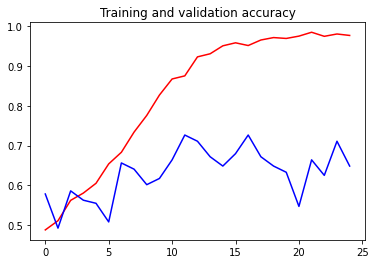

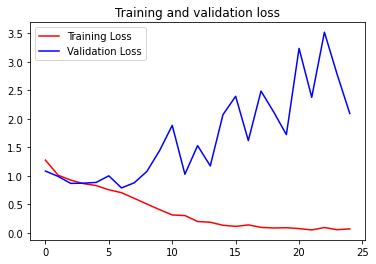

In [98]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()